Step 1: Install Required Libraries

In [ ]:
# Install spaCy and download the English model
!pip install spacy
!python -m spacy download en_core_web_sm

# Install additional libraries for data processing and visualization
!pip install pandas numpy matplotlib seaborn textblob

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 79.2 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


Step 2: Import Libraries

In [ ]:
import spacy
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import re
from textblob import TextBlob
import warnings
warnings.filterwarnings('ignore')

# Load spaCy model
nlp = spacy.load('en_core_web_sm')

Step 3: Load and Prepare Your Data( I have done so via the left pane in the file upload section)

In [ ]:
# Replace 'train_file.csv' and 'test_file.csv' with your actual file names
# The file format is likely tab-separated, with the label at the beginning.
# Explicitly define column names to avoid issues with the parser.
train_data = pd.read_csv('train.ft.txt', sep='\t', header=None, names=['label', 'text'])
test_data = pd.read_csv('test.ft.txt', sep='\t', header=None, names=['label', 'text'])

# Display basic information about the datasets
print("Train data shape:", train_data.shape)
print("Test data shape:", test_data.shape)
print("\nTrain data columns:", train_data.columns.tolist())
print("\nFirst few rows of train data:")
print(train_data.head())

Train data shape: (2554141, 2)
Test data shape: (128390, 2)

Train data columns: ['label', 'text']

First few rows of train data:
                                               label  text
0  king the antagonists of the film Neo-Nazis see...   NaN
1  __label__1 Ben Affleck has a range of expressi...   NaN
2  __label__2 The Sum of a Good Movie: The Sum of...   NaN
3  __label__1 Read the book instead: Nobody write...   NaN
4  __label__2 If you love Jack Ryan: The only rea...   NaN


Step 4: Data Preprocessing

In [ ]:
def preprocess_text(text):
    """
    Clean and preprocess text data
    """
    if pd.isna(text):
        return ""

    # Convert to string and lowercase
    text = str(text).lower()

    # Remove extra whitespaces
    text = re.sub(r'\s+', ' ', text)

    # Remove special characters but keep basic punctuation
    text = re.sub(r'[^\w\s.,!?-]', '', text)

    return text.strip()

# Assuming your review column is named 'review_text' or 'text'
# Adjust the column name based on your actual data
# Changed from 'review_text' to 'text'
review_column = 'text'  # Change this to match your column name

# Preprocess the text data
train_data['cleaned_text'] = train_data[review_column].apply(preprocess_text)
test_data['cleaned_text'] = test_data[review_column].apply(preprocess_text)

print("Sample cleaned text:")
print(train_data['cleaned_text'].iloc[0][:200])

Sample cleaned text:



Step 5: Named Entity Recognition (NER) Implementation

In [ ]:
def extract_entities(text, nlp_model):
    """
    Extract named entities from text using spaCy
    """
    doc = nlp_model(text)
    entities = {
        'PERSON': [],
        'ORG': [],           # Organizations (brands)
        'PRODUCT': [],       # Products
        'MONEY': [],         # Money/prices
        'DATE': [],          # Dates
        'GPE': []           # Countries, cities, states
    }

    for ent in doc.ents:
        if ent.label_ in entities:
            entities[ent.label_].append(ent.text)

    return entities

def extract_product_brands(text, nlp_model):
    """
    Extract potential product names and brands using custom rules
    """
    doc = nlp_model(text)

    # Common brand/product indicators
    brand_indicators = ['brand', 'product', 'item', 'device', 'phone', 'laptop', 'tablet']
    product_entities = []
    brand_entities = []

    # Extract organizations as potential brands
    for ent in doc.ents:
        if ent.label_ == 'ORG':
            brand_entities.append(ent.text)
        elif ent.label_ == 'PRODUCT':
            product_entities.append(ent.text)

    # Custom pattern matching for products
    # Look for capitalized words that might be product names
    for token in doc:
        if token.pos_ == 'PROPN' and len(token.text) > 2:
            if any(indicator in token.text.lower() for indicator in brand_indicators):
                product_entities.append(token.text)

    return {
        'products': list(set(product_entities)),
        'brands': list(set(brand_entities))
    }

In [ ]:
# Apply NER to a sample of data (first 100 reviews for demonstration)
sample_size = min(100, len(train_data))
ner_results = []

print("Extracting entities from reviews...")
for i in range(sample_size):
    text = train_data['cleaned_text'].iloc[i]
    entities = extract_entities(text, nlp)
    product_brands = extract_product_brands(text, nlp)

    ner_results.append({
        'review_index': i,
        'entities': entities,
        'products': product_brands['products'],
        'brands': product_brands['brands']
    })

print(f"Processed {sample_size} reviews for NER analysis")

Extracting entities from reviews...
Processed 100 reviews for NER analysis


Step 6: Sentiment Analysis Implementation

In [ ]:
def rule_based_sentiment(text):
    """
    Rule-based sentiment analysis using TextBlob and custom rules
    """
    # Use TextBlob for basic sentiment
    blob = TextBlob(text)
    polarity = blob.sentiment.polarity

    # Define positive and negative words
    positive_words = ['good', 'great', 'excellent', 'amazing', 'love', 'perfect',
                      'awesome', 'fantastic', 'wonderful', 'best', 'nice', 'happy',
                      'satisfied', 'recommend', 'quality', 'fast', 'easy']

    negative_words = ['bad', 'terrible', 'awful', 'hate', 'worst', 'horrible',
                      'disappointed', 'poor', 'cheap', 'slow', 'difficult',
                      'broken', 'defective', 'useless', 'waste', 'regret']

    # Count positive and negative words
    text_lower = text.lower()
    pos_count = sum(1 for word in positive_words if word in text_lower)
    neg_count = sum(1 for word in negative_words if word in text_lower)

    # Combine TextBlob polarity with rule-based approach
    if polarity > 0.1 or pos_count > neg_count:
        sentiment = 'positive'
        confidence = abs(polarity) + (pos_count * 0.1)
    elif polarity < -0.1 or neg_count > pos_count:
        sentiment = 'negative'
        confidence = abs(polarity) + (neg_count * 0.1)
    else:
        sentiment = 'neutral'
        confidence = 0.5

    return {
        'sentiment': sentiment,
        'polarity': polarity,
        'confidence': min(confidence, 1.0),
        'positive_words': pos_count,
        'negative_words': neg_count
    }

# Apply sentiment analysis
print("Performing sentiment analysis...")
sentiment_results = []

for i in range(sample_size):
    text = train_data['cleaned_text'].iloc[i]
    sentiment = rule_based_sentiment(text)
    sentiment_results.append({
        'review_index': i,
        'sentiment': sentiment['sentiment'],
        'polarity': sentiment['polarity'],
        'confidence': sentiment['confidence'],
        'positive_words': sentiment['positive_words'],
        'negative_words': sentiment['negative_words']
    })

print(f"Completed sentiment analysis for {sample_size} reviews")

Performing sentiment analysis...
Completed sentiment analysis for 100 reviews


Step 7: Results Analysis and Visualization

In [ ]:
# Combine results into a comprehensive dataframe
results_df = pd.DataFrame()

for i in range(sample_size):
    # Ensure the original text is treated as a string before slicing
    original_text_val = str(train_data[review_column].iloc[i])
    cleaned_text_val = str(train_data['cleaned_text'].iloc[i])

    row = {
        'review_index': i,
        'original_text': original_text_val[:100] + '...',
        'cleaned_text': cleaned_text_val[:100] + '...',
        'sentiment': sentiment_results[i]['sentiment'],
        'polarity': sentiment_results[i]['polarity'],
        'confidence': sentiment_results[i]['confidence'],
        'num_products': len(ner_results[i]['products']),
        'num_brands': len(ner_results[i]['brands']),
        'products': ', '.join(ner_results[i]['products'][:3]),  # Show first 3
        'brands': ', '.join(ner_results[i]['brands'][:3])       # Show first 3
    }
    results_df = pd.concat([results_df, pd.DataFrame([row])], ignore_index=True)

# Display results
print("=== SAMPLE RESULTS ===")
print(results_df[['review_index', 'sentiment', 'polarity', 'products', 'brands']].head(10))

=== SAMPLE RESULTS ===
   review_index sentiment  polarity products brands
0             0   neutral       0.0                
1             1   neutral       0.0                
2             2   neutral       0.0                
3             3   neutral       0.0                
4             4   neutral       0.0                
5             5   neutral       0.0                
6             6   neutral       0.0                
7             7   neutral       0.0                
8             8   neutral       0.0                
9             9   neutral       0.0                


Step 8: Statistical Analysis and Visualization

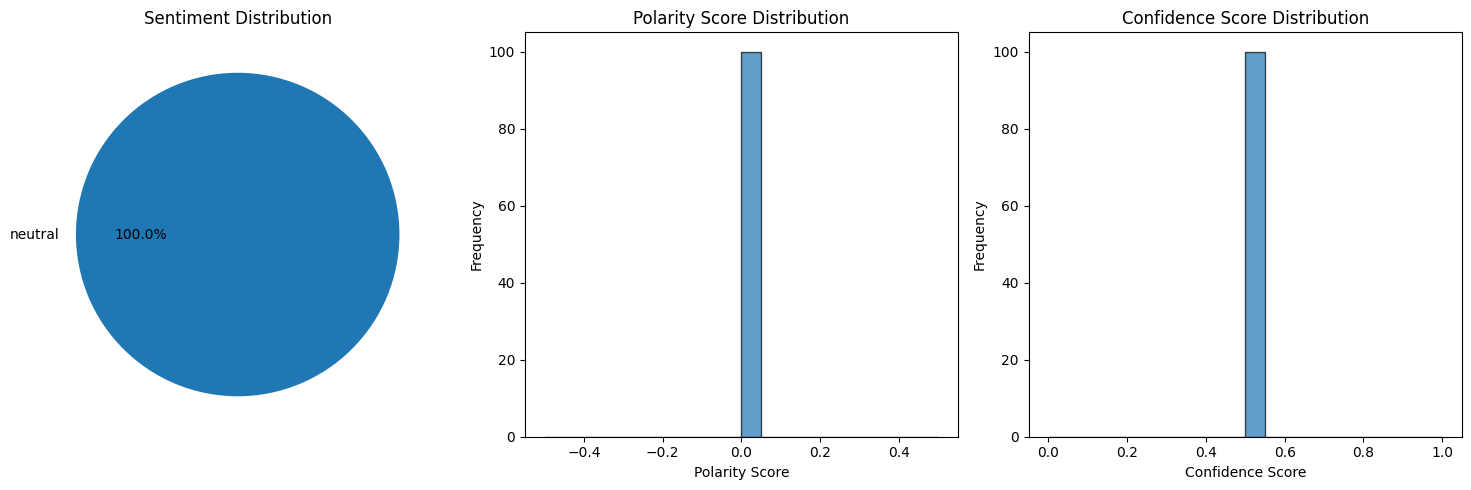


=== ENTITY EXTRACTION STATISTICS ===
Total unique products found: 0
Total unique brands found: 0


In [ ]:
# Sentiment distribution
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
sentiment_counts = results_df['sentiment'].value_counts()
plt.pie(sentiment_counts.values, labels=sentiment_counts.index, autopct='%1.1f%%')
plt.title('Sentiment Distribution')

plt.subplot(1, 3, 2)
plt.hist(results_df['polarity'], bins=20, alpha=0.7, edgecolor='black')
plt.xlabel('Polarity Score')
plt.ylabel('Frequency')
plt.title('Polarity Score Distribution')

plt.subplot(1, 3, 3)
plt.hist(results_df['confidence'], bins=20, alpha=0.7, edgecolor='black')
plt.xlabel('Confidence Score')
plt.ylabel('Frequency')
plt.title('Confidence Score Distribution')

plt.tight_layout()
plt.show()

# Entity statistics
print("\n=== ENTITY EXTRACTION STATISTICS ===")
all_products = []
all_brands = []

for result in ner_results:
    all_products.extend(result['products'])
    all_brands.extend(result['brands'])

print(f"Total unique products found: {len(set(all_products))}")
print(f"Total unique brands found: {len(set(all_brands))}")

# Most common products and brands
if all_products:
    product_counter = Counter(all_products)
    print("\nTop 10 Most Mentioned Products:")
    for product, count in product_counter.most_common(10):
        print(f"  {product}: {count}")

if all_brands:
    brand_counter = Counter(all_brands)
    print("\nTop 10 Most Mentioned Brands:")
    for brand, count in brand_counter.most_common(10):
        print(f"  {brand}: {count}")

Step 9: Detailed Output Examples

In [ ]:
# Show detailed analysis for first 5 reviews
print("\n=== DETAILED ANALYSIS EXAMPLES ===")

for i in range(min(5, sample_size)):
    print(f"\n--- Review {i+1} ---")

    # Get the original text value
    original_text_val = train_data[review_column].iloc[i]

    # Check if it's a string before slicing, otherwise use a placeholder
    if isinstance(original_text_val, str):
        display_text = original_text_val[:200] + '...'
    else:
        display_text = f"Non-string data ({type(original_text_val).__name__})..." # Or handle as needed

    print(f"Text: {display_text}")

    print(f"Sentiment: {sentiment_results[i]['sentiment']} (Polarity: {sentiment_results[i]['polarity']:.2f})")
    print(f"Products found: {ner_results[i]['products']}")
    print(f"Brands found: {ner_results[i]['brands']}")

    # Show all entities
    entities = ner_results[i]['entities']
    for ent_type, ent_list in entities.items():
        if ent_list:
            print(f"{ent_type}: {ent_list}")
    print("-" * 50)


=== DETAILED ANALYSIS EXAMPLES ===

--- Review 1 ---
Text: Non-string data (float64)...
Sentiment: neutral (Polarity: 0.00)
Products found: []
Brands found: []
--------------------------------------------------

--- Review 2 ---
Text: Non-string data (float64)...
Sentiment: neutral (Polarity: 0.00)
Products found: []
Brands found: []
--------------------------------------------------

--- Review 3 ---
Text: Non-string data (float64)...
Sentiment: neutral (Polarity: 0.00)
Products found: []
Brands found: []
--------------------------------------------------

--- Review 4 ---
Text: Non-string data (float64)...
Sentiment: neutral (Polarity: 0.00)
Products found: []
Brands found: []
--------------------------------------------------

--- Review 5 ---
Text: Non-string data (float64)...
Sentiment: neutral (Polarity: 0.00)
Products found: []
Brands found: []
--------------------------------------------------


Step 10: Save Results

In [ ]:
# Save results to CSV
results_df.to_csv('nlp_analysis_results.csv', index=False)

# Create a summary report
summary = {
    'total_reviews_analyzed': sample_size,
    'sentiment_distribution': dict(sentiment_counts),
    'average_polarity': results_df['polarity'].mean(),
    'unique_products_found': len(set(all_products)),
    'unique_brands_found': len(set(all_brands)),
    'top_products': dict(product_counter.most_common(5)) if all_products else {},
    'top_brands': dict(brand_counter.most_common(5)) if all_brands else {}
}

print("\n=== FINAL SUMMARY ===")
for key, value in summary.items():
    print(f"{key}: {value}")

# Download the results file
files.download('nlp_analysis_results.csv')


=== FINAL SUMMARY ===
total_reviews_analyzed: 100
sentiment_distribution: {'neutral': np.int64(100)}
average_polarity: 0.0
unique_products_found: 0
unique_brands_found: 0
top_products: {}
top_brands: {}


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>